# DF CON VARIABLES DE 4 HORAS #

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error


In [2]:
import requests
import pandas as pd
import time

def get_binance_ohlcv(symbol="BTCUSDT", interval="1h", days=1095):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume"]]

# ======================
# 🚀 Descargar datos
# ======================
df = get_binance_ohlcv("BTCUSDT", "1h", days=1095)

# guardar en CSV
df.to_csv("BTCUSDT_1h_3years.csv", index=False)

print("✅ Datos descargados y guardados en BTCUSDT_1h_3years.csv")
print(df.head())
print(df.tail())


✅ Datos descargados y guardados en BTCUSDT_1h_3years.csv
            open_time      open      high       low     close       volume
0 2022-09-26 00:00:00  18809.13  18932.35  18746.66  18772.96  16884.71629
1 2022-09-26 01:00:00  18772.96  18913.95  18721.02  18879.43  14488.05360
2 2022-09-26 02:00:00  18879.43  18940.00  18838.61  18855.02  14757.82752
3 2022-09-26 03:00:00  18853.82  18948.11  18831.02  18868.39  14176.20258
4 2022-09-26 04:00:00  18869.07  18918.96  18797.84  18808.23  11659.19988
                open_time       open       high        low      close  \
26274 2025-09-24 19:00:00  113639.80  113682.46  113292.25  113420.01   
26275 2025-09-24 20:00:00  113420.00  113609.25  113401.99  113501.52   
26276 2025-09-24 21:00:00  113501.52  113584.02  113283.99  113339.63   
26277 2025-09-24 22:00:00  113339.63  113647.58  113250.59  113336.33   
26278 2025-09-24 23:00:00  113336.34  113412.38  113217.09  113226.15   

          volume  
26274  306.51270  
26275  233.37909

In [3]:
df

,open_time,open,high,low,close,volume
0,2022-09-26 00:00:00,18809.13,18932.35,18746.66,18772.96,16884.71629
1,2022-09-26 01:00:00,18772.96,18913.95,18721.02,18879.43,14488.05360
2,2022-09-26 02:00:00,18879.43,18940.00,18838.61,18855.02,14757.82752
3,2022-09-26 03:00:00,18853.82,18948.11,18831.02,18868.39,14176.20258
4,2022-09-26 04:00:00,18869.07,18918.96,18797.84,18808.23,11659.19988
...,...,...,...,...,...,...
26274,2025-09-24 19:00:00,113639.80,113682.46,113292.25,113420.01,306.51270
26275,2025-09-24 20:00:00,113420.00,113609.25,113401.99,113501.52,233.37909
26276,2025-09-24 21:00:00,113501.52,113584.02,113283.99,113339.63,274.44453
26277,2025-09-24 22:00:00,113339.63,113647.58,113250.59,113336.33,268.57434


In [4]:
#df=pd.read_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/src/BTCUSDT_1h_3years.csv")+

In [5]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100

porcentaje(df,"close",1,"1hora%")
porcentaje(df,"close",4,"4hora%")
porcentaje(df,"close",8,"8hora%")
porcentaje(df,"close",24,"dia%")
porcentaje(df,"close",48,"2dias%")
porcentaje(df,"close",24*7,"1semana%")
porcentaje(df,"close",24*7*2,"2semanas%")
porcentaje(df,"close",24*7*4,"1mes%")
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [9]:
df_porcentual=df

In [7]:
df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [10]:

def calcular_RSI(df, column="close", period=14):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,2dias%,1semana%,2semanas%,1mes%,RSI
0,2022-10-24 00:00:00,19570.40,19601.15,19491.84,19518.82,13256.66937,0.263561,-0.113815,-1.775336,-1.683664,-1.847719,-1.499602,-0.140575,-3.973055,NaN
1,2022-10-24 01:00:00,19518.14,19527.72,19366.00,19412.47,14512.13410,0.544859,0.643102,0.326299,-1.216160,-1.339802,-1.225396,0.456172,-2.823390,0.000000
2,2022-10-24 02:00:00,19411.49,19477.45,19390.88,19414.68,8260.47764,-0.011384,0.909919,0.119098,-1.134085,-1.495668,-1.095168,0.292067,-2.968228,0.318680
3,2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.90396,0.116973,0.911734,0.553133,-1.012523,-1.257100,-1.071541,0.313679,-2.774906,0.307077
4,2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.78988,0.288315,0.936327,0.823578,-0.785915,-0.981032,-0.571146,0.671758,-2.806378,0.278294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-24 19:00:00,113639.80,113682.46,113292.25,113420.01,306.51270,0.193409,-0.064934,-0.345529,-1.580507,-1.156864,1.929936,0.136043,-1.194961,57.108424
25603,2025-09-24 20:00:00,113420.00,113609.25,113401.99,113501.52,233.37909,-0.071866,0.202661,-0.381027,-1.353520,-0.638081,1.833526,0.057121,-0.962870,59.233416
25604,2025-09-24 21:00:00,113501.52,113584.02,113283.99,113339.63,274.44453,0.142632,0.370662,-0.457360,-1.050351,-0.327202,2.325748,0.441751,-1.624199,53.193875
25605,2025-09-24 22:00:00,113339.63,113647.58,113250.59,113336.33,268.57434,0.002912,0.267046,0.337942,-1.049490,-0.615288,2.765416,0.478455,-1.729466,53.066612


In [11]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 200]):
    """
    Agrega columnas de EMAs al DataFrame.
    
    Parámetros:
        df: DataFrame con los precios.
        column: columna sobre la cual calcular las EMAs (default: 'close').
        spans: lista de periodos para calcular las EMAs.
        
    Retorna:
        DataFrame con nuevas columnas EMA_x.
    """
    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,2dias%,1semana%,2semanas%,1mes%,RSI,EMA_9,EMA_21,EMA_50,EMA_200
0,2022-10-24 00:00:00,19570.40,19601.15,19491.84,19518.82,13256.66937,0.263561,-0.113815,-1.775336,-1.683664,-1.847719,-1.499602,-0.140575,-3.973055,NaN,19518.820000,19518.820000,19518.820000,19518.820000
1,2022-10-24 01:00:00,19518.14,19527.72,19366.00,19412.47,14512.13410,0.544859,0.643102,0.326299,-1.216160,-1.339802,-1.225396,0.456172,-2.823390,0.000000,19497.550000,19509.151818,19514.649412,19517.761791
2,2022-10-24 02:00:00,19411.49,19477.45,19390.88,19414.68,8260.47764,-0.011384,0.909919,0.119098,-1.134085,-1.495668,-1.095168,0.292067,-2.968228,0.318680,19480.976000,19500.563471,19510.729043,19516.736102
3,2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.90396,0.116973,0.911734,0.553133,-1.012523,-1.257100,-1.071541,0.313679,-2.774906,0.307077,19463.174800,19490.691337,19506.071825,19515.494648
4,2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.78988,0.288315,0.936327,0.823578,-0.785915,-0.981032,-0.571146,0.671758,-2.806378,0.278294,19437.751840,19476.633943,19499.404695,19513.709228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2025-09-24 19:00:00,113639.80,113682.46,113292.25,113420.01,306.51270,0.193409,-0.064934,-0.345529,-1.580507,-1.156864,1.929936,0.136043,-1.194961,57.108424,113371.008622,113035.272864,113010.657854,114228.236777
25603,2025-09-24 20:00:00,113420.00,113609.25,113401.99,113501.52,233.37909,-0.071866,0.202661,-0.381027,-1.353520,-0.638081,1.833526,0.057121,-0.962870,59.233416,113397.110898,113077.658967,113029.907350,114221.005765
25604,2025-09-24 21:00:00,113501.52,113584.02,113283.99,113339.63,274.44453,0.142632,0.370662,-0.457360,-1.050351,-0.327202,2.325748,0.441751,-1.624199,53.193875,113385.614718,113101.474515,113042.053337,114212.235856
25605,2025-09-24 22:00:00,113339.63,113647.58,113250.59,113336.33,268.57434,0.002912,0.267046,0.337942,-1.049490,-0.615288,2.765416,0.478455,-1.729466,53.066612,113375.757774,113122.825014,113053.593598,114203.520375


In [45]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=50):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [46]:
resistencias

,price_level,volume
0,16731.5031,1.332599e+07
1,23223.4017,1.100343e+07
2,21059.4355,9.789748e+06
3,27551.3341,6.110521e+06
4,25387.3679,5.078025e+06
5,29715.3003,2.942384e+06
6,18895.4693,2.705991e+06
7,42699.0975,1.565810e+06
8,66502.7257,1.426814e+06
9,62174.7933,1.296323e+06


In [47]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [48]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [49]:
#df_porcentual.drop(columns="resistencia",axis=1,inplace=True)
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,RSI,EMA_9,EMA_21,EMA_50,EMA_200,pred_dia%,resistencia
0,2022-10-24 01:00:00,19518.14,19527.72,19366.00,19412.47,14512.13410,0.544859,0.643102,0.326299,-1.216160,...,-1.225396,0.456172,-2.823390,0.000000,19497.550000,19509.151818,19514.649412,19517.761791,0.591579,0
1,2022-10-24 02:00:00,19411.49,19477.45,19390.88,19414.68,8260.47764,-0.011384,0.909919,0.119098,-1.134085,...,-1.095168,0.292067,-2.968228,0.318680,19480.976000,19500.563471,19510.729043,19516.736102,0.529393,0
2,2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.90396,0.116973,0.911734,0.553133,-1.012523,...,-1.071541,0.313679,-2.774906,0.307077,19463.174800,19490.691337,19506.071825,19515.494648,0.257581,0
3,2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.78988,0.288315,0.936327,0.823578,-0.785915,...,-0.571146,0.671758,-2.806378,0.278294,19437.751840,19476.633943,19499.404695,19513.709228,-0.030513,0
4,2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.15179,-0.001914,0.391707,1.032290,-0.820951,...,-0.333278,0.386524,-3.018784,0.349618,19417.487472,19463.888130,19493.013530,19511.945256,-0.000931,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25577,2025-09-23 19:00:00,111780.09,111979.27,111540.20,111655.29,565.08344,0.111657,1.086885,1.169009,0.417051,...,4.404816,-0.317839,-0.485313,22.021044,112322.988193,112590.764220,113207.463252,114623.151791,-1.580507,0
25578,2025-09-23 20:00:00,111655.29,111994.99,111458.73,111985.77,495.90964,-0.295982,0.742628,0.845795,0.705885,...,4.154161,-0.408508,-0.596641,36.556919,112255.544555,112535.764745,113159.553713,114596.909186,-1.353520,0
25579,2025-09-23 21:00:00,111985.78,112202.24,111893.44,112161.54,270.56814,-0.156957,-0.182015,0.700092,0.715633,...,3.971704,-0.774423,-0.517043,43.069542,112236.743644,112501.744314,113120.415920,114572.676657,-1.050351,0
25580,2025-09-23 22:00:00,112161.53,112213.95,112002.16,112159.23,231.71626,0.002060,-0.339175,0.438231,0.429693,...,4.018935,-0.540598,-0.222697,43.002602,112221.240915,112470.606649,113082.722355,114548.662263,-1.049490,0


In [ ]:
#zonas de bajo volumen, mayor movimiento


In [21]:
df_porcentual

,open_time,open,high,low,close,volume,1hora%,4hora%,8hora%,dia%,...,1semana%,2semanas%,1mes%,RSI,EMA_9,EMA_21,EMA_50,EMA_200,resistencia,pred_dia%
0,2022-10-24 01:00:00,19518.14,19527.72,19366.00,19412.47,14512.13410,0.544859,0.643102,0.326299,-1.216160,...,-1.225396,0.456172,-2.823390,0.000000,19497.550000,19509.151818,19514.649412,19517.761791,0,0.591579
1,2022-10-24 02:00:00,19411.49,19477.45,19390.88,19414.68,8260.47764,-0.011384,0.909919,0.119098,-1.134085,...,-1.095168,0.292067,-2.968228,0.318680,19480.976000,19500.563471,19510.729043,19516.736102,0,0.529393
2,2022-10-24 03:00:00,19414.97,19435.52,19342.33,19391.97,10196.90396,0.116973,0.911734,0.553133,-1.012523,...,-1.071541,0.313679,-2.774906,0.307077,19463.174800,19490.691337,19506.071825,19515.494648,1,0.257581
3,2022-10-24 04:00:00,19391.97,19392.41,19260.00,19336.06,10574.78988,0.288315,0.936327,0.823578,-0.785915,...,-0.571146,0.671758,-2.806378,0.278294,19437.751840,19476.633943,19499.404695,19513.709228,0,-0.030513
4,2022-10-24 05:00:00,19336.06,19355.70,19292.65,19336.43,7984.15179,-0.001914,0.391707,1.032290,-0.820951,...,-0.333278,0.386524,-3.018784,0.349618,19417.487472,19463.888130,19493.013530,19511.945256,0,-0.000931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25577,2025-09-23 19:00:00,111780.09,111979.27,111540.20,111655.29,565.08344,0.111657,1.086885,1.169009,0.417051,...,4.404816,-0.317839,-0.485313,22.021044,112322.988193,112590.764220,113207.463252,114623.151791,0,-1.580507
25578,2025-09-23 20:00:00,111655.29,111994.99,111458.73,111985.77,495.90964,-0.295982,0.742628,0.845795,0.705885,...,4.154161,-0.408508,-0.596641,36.556919,112255.544555,112535.764745,113159.553713,114596.909186,0,-1.353520
25579,2025-09-23 21:00:00,111985.78,112202.24,111893.44,112161.54,270.56814,-0.156957,-0.182015,0.700092,0.715633,...,3.971704,-0.774423,-0.517043,43.069542,112236.743644,112501.744314,113120.415920,114572.676657,0,-1.050351
25580,2025-09-23 22:00:00,112161.53,112213.95,112002.16,112159.23,231.71626,0.002060,-0.339175,0.438231,0.429693,...,4.018935,-0.540598,-0.222697,43.002602,112221.240915,112470.606649,113082.722355,114548.662263,0,-1.049490


In [56]:
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(81):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[20000+i:25500+i]
    outsider=df_porcentual[25500+i+1:25500+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=RandomForestRegressor( n_estimators=50, random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [51]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 1.549845278910964
n_aciertos: 0.675
error total: 0.4965136434211215


error_aciertos: 1.3276704849230145
n_aciertos: 0.69
error total: 0.3441753306724004
mejor de momento 15k muestras-60 arboles
error_aciertos: 0.8455168662221639
n_aciertos: 0.77
error total: 1.9687349553493934

<Axes: xlabel='None', ylabel='real'>

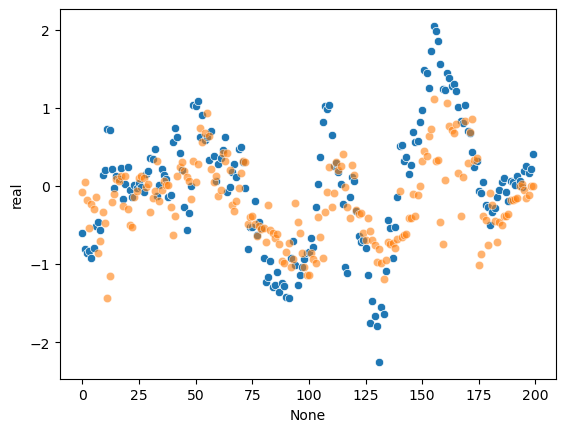

In [55]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [53]:
guardados

,real,predicciones,dif
0,-0.601295,-0.078062,NaN
1,-0.808367,0.049024,NaN
2,-0.858181,-0.173509,NaN
3,-0.832434,-0.534439,NaN
4,-0.923008,-0.228109,NaN
...,...,...,...
195,0.194587,-0.047480,NaN
196,0.250755,-0.158467,NaN
197,0.164747,-0.109588,NaN
198,0.219254,0.005733,NaN


In [54]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


114573.06170026894
115063.59361605856
115107.72060122369
114691.53043541568
115116.79749356546
115181.11859829552
115121.85101131874
114364.99400869389
114275.3085980193
114646.76964288941
114483.81346204085
113649.31909674764
114177.0020849085
115703.23093138702
115645.75977462469
115730.8934217738
115586.7687426029
115326.73221417583
115071.47875074059
115146.13772007587
115094.71661911669
114618.60328021777
114689.69472562423
115744.04581115126
115993.8119529187
116335.05731567097
116274.10655487391
116685.26376677785
116831.554034947
116765.80170394057
116465.67088677075
116614.80903325521
116486.51137891939
116288.56191752048
116459.33306693626
116317.95766443638
116241.2150709662
117088.30912444963
117224.63177391552
116840.75868062385
116125.7731163141
116096.05461983828
116217.47359213971
115976.46990630422
115846.927658182
115891.13475052272
115466.38231431802
115808.22394482403
115450.56345022505
115140.43459644653
115171.40986567983
115319.4183798048
114768.64823307461
11538

In [27]:
comparacion

,real,prediccion
0,115747.54,115279.099181
1,115894.06,115606.234911
2,115874.49,115363.561716
3,115915.80,115017.200651
4,115970.36,115193.413649
...,...,...
81,111655.29,111026.845493
82,111985.77,111647.080010
83,112161.54,111889.568043
84,112159.23,111601.215812


# XGBoots #

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [40]:

relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=["open_time","pred_dia%"]
medir="pred_dia%"
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[20000+i:25300+i]
    outsider=df_porcentual[25300+i+1:25300+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
    model=XGBRegressor(random_state=42,colsample_bytree=1.0, gamma= 0.5, learning_rate= 0.04 ,min_child_weight= 5, n_estimators= 1000, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    if y_outsider[0]*predicciones_outsider>0:
        aciertos_direccion_list.append(predicciones_outsider)
        error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        error_aciertos_list.append(error_relativo_aciertos)

error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
aciertos_direccion=len(aciertos_direccion_list)
error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [41]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 3.735262280252621
n_aciertos: 0.67
error total: 1.1796122984997532


<Axes: xlabel='None', ylabel='real'>

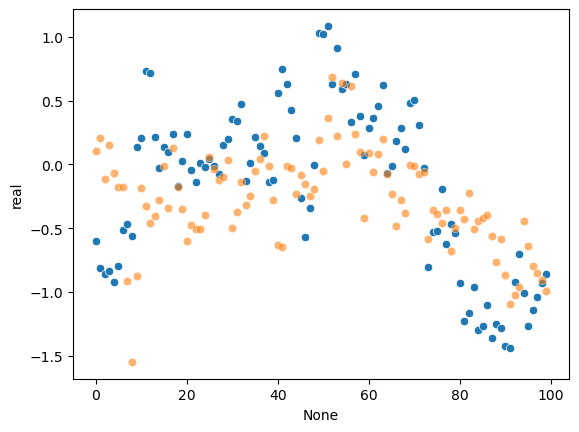

In [42]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)